In [33]:
import os
import scanpy as sc
from functools import reduce
import rapids_singlecell as rsc
import pandas as pd
os.listdir("../dataset/rawdataset")

['GSE138266_RAW',
 'GSE144744',
 'GSE138266.h5ad',
 'GSE138266_PBMC.h5ad',
 'GSE138266_CSF.h5ad',
 'GSE194078',
 'gse194078.h5ad',
 '.ipynb_checkpoints',
 'gse194078.csf.h5ad',
 'gse194078.pbmc.h5ad',
 'gse144744.h5ad']

In [34]:
dataset_dir = "../dataset/rawdataset"

gse138266 = sc.read_h5ad(f"{dataset_dir}/GSE138266_CSF.h5ad")
gse194078 = sc.read_h5ad(f"{dataset_dir}/gse194078.csf.h5ad")

gse138266.obs['dataset'] = "gse138266"
gse194078.obs['dataset'] = "gse194078"

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [35]:
# andiamo a mettere tutto in una lista 
anndatas = [gse138266, gse194078]
#prendiamo i geni comuni a tutti                 
common_genes = reduce(lambda x, y: x.intersection(y), [adata.var_names for adata in anndatas])
print(f"Common genes: {len(common_genes)}")
# Manteniamo solo i comuni
anndatas = [adata[:, common_genes] for adata in anndatas]

# vogliamo fare lo stesso per le colonne comuni
common_obs_columns = reduce(lambda x, y: x.intersection(y), [adata.obs.columns for adata in anndatas])
print(f"Obs comuni: {common_obs_columns}")
for adata in anndatas:
    adata.obs = adata.obs[common_obs_columns]  # Subset .obs columns


Common genes: 18122
Obs comuni: Index(['condition', 'sample', 'tissue', 'n_genes_by_counts',
       'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts',
       'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes',
       'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes',
       'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes',
       'n_counts', 'predicted_labels', 'over_clustering', 'majority_voting',
       'dataset'],
      dtype='object')


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [36]:
# andiamo a metterli tutti insieme
import anndata
concat_anndata = anndata.concat(anndatas, join='inner', merge="same")
concat_anndata

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 52262 × 18122
    obs: 'condition', 'sample', 'tissue', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'predicted_labels', 'over_clustering', 'majority_voting', 'dataset'
    var: 'mt'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

In [37]:
print(concat_anndata)

import numpy as np

# Convert sparse matrix to dense matrix
dense_matrix = concat_anndata.X.toarray()

# Check for NaN values
has_nan = np.isnan(dense_matrix).any()

print("Contains NaN values:", has_nan)
#del concat_anndata.obsm["X_pca"]
#del concat_anndata.obsm["X_umap"]
# Rimuovi il grafo dei vicini
#if "neighbors" in gse227954.uns:
#    del concat_anndata.uns["neighbors"]

#if "distances" in gse227954.obsp:
#    del concat_anndata.obsp["distances"]

#if "connectivities" in gse227954.obsp:
#    del concat_anndata.obsp["connectivities"]

import numpy as np
import scipy.sparse as sp

# Ensure sparse matrix is in CSR format (efficient row-wise operations)
if sp.issparse(concat_anndata.X):
    concat_anndata = concat_anndata[:, np.array(concat_anndata.X.sum(axis=0)).flatten() > 0]
else:
    concat_anndata = concat_anndata[:, np.any(concat_anndata.X > 0, axis=0)]
    
print(concat_anndata)

AnnData object with n_obs × n_vars = 52262 × 18122
    obs: 'condition', 'sample', 'tissue', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'predicted_labels', 'over_clustering', 'majority_voting', 'dataset'
    var: 'mt'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'
Contains NaN values: False
View of AnnData object with n_obs × n_vars = 52262 × 17820
    obs: 'condition', 'sample', 'tissue', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'predicted_labels', 'over_clustering', 'majority_voting', 'dat

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


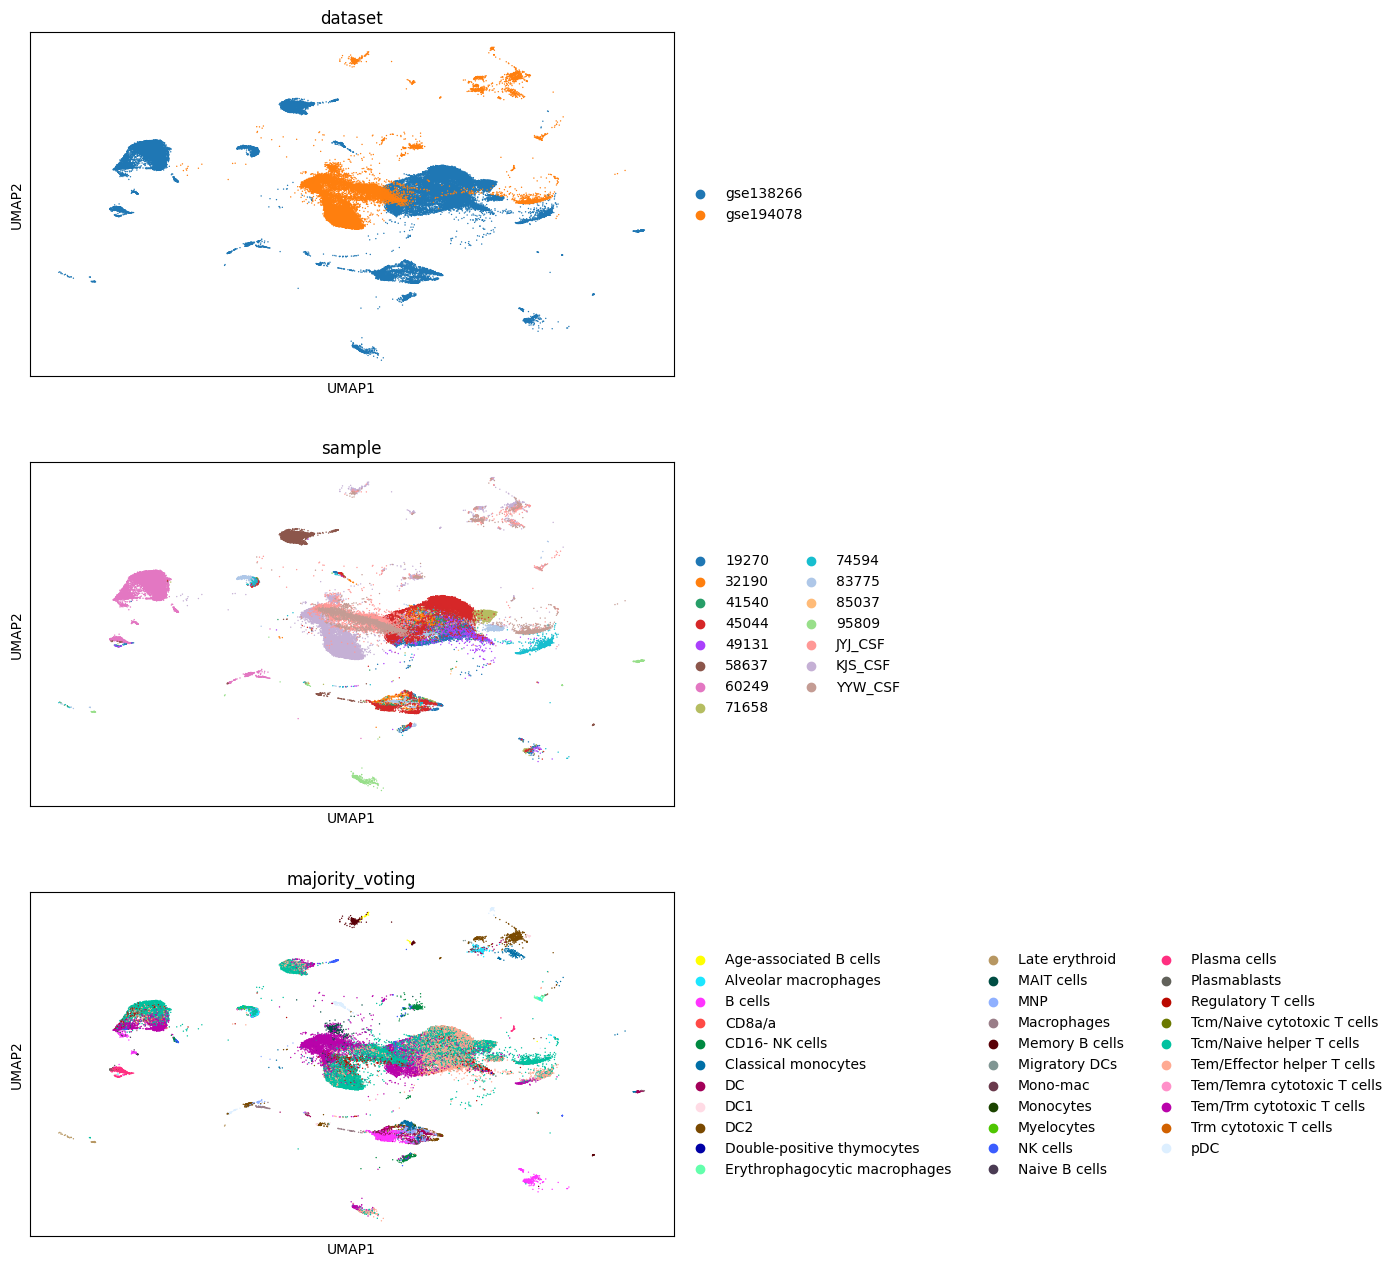

In [38]:
sc.pl.umap(
    concat_anndata,
    color=["dataset", "sample", "majority_voting"],
    size=4,
    wspace=0.4,
    ncols=1
)

In [39]:
print("Running PCA...")
rsc.pp.pca(
    concat_anndata,
    n_comps=50,  # Or another value based on the dataset's complexity.
    svd_solver="auto",  # Let Scanpy choose the best solver.
    random_state=0,  # For reproducibility.  Remove if not needed.
    zero_center=True,  # Center data before PCA.  Generally a good idea.
)

print("Finding neighbors...")
rsc.pp.neighbors(
    concat_anndata,
    n_neighbors=60,  # Adjust based on dataset size; higher for larger datasets.
    n_pcs=None,  # Use all computed PCs; reduce if memory is an issue.
    use_rep="X_pca",  # Specify PCA result as the basis for neighbor search.
    random_state=0,  # For reproducibility.  Remove if not needed.
)

print("Running UMAP on GPU")
rsc.tl.umap(
    concat_anndata,
    #min_dist=0.2,  # Adjust for clumpiness of the embedding.
    #spread=1.5,  # Adjust the balance between local and global structure.
    random_state=0,  # For reproducibility.  Remove if not needed.
    # use_gpu=True, #Enable it in your scanpy setting
)

Running PCA...
Finding neighbors...
Running UMAP on GPU


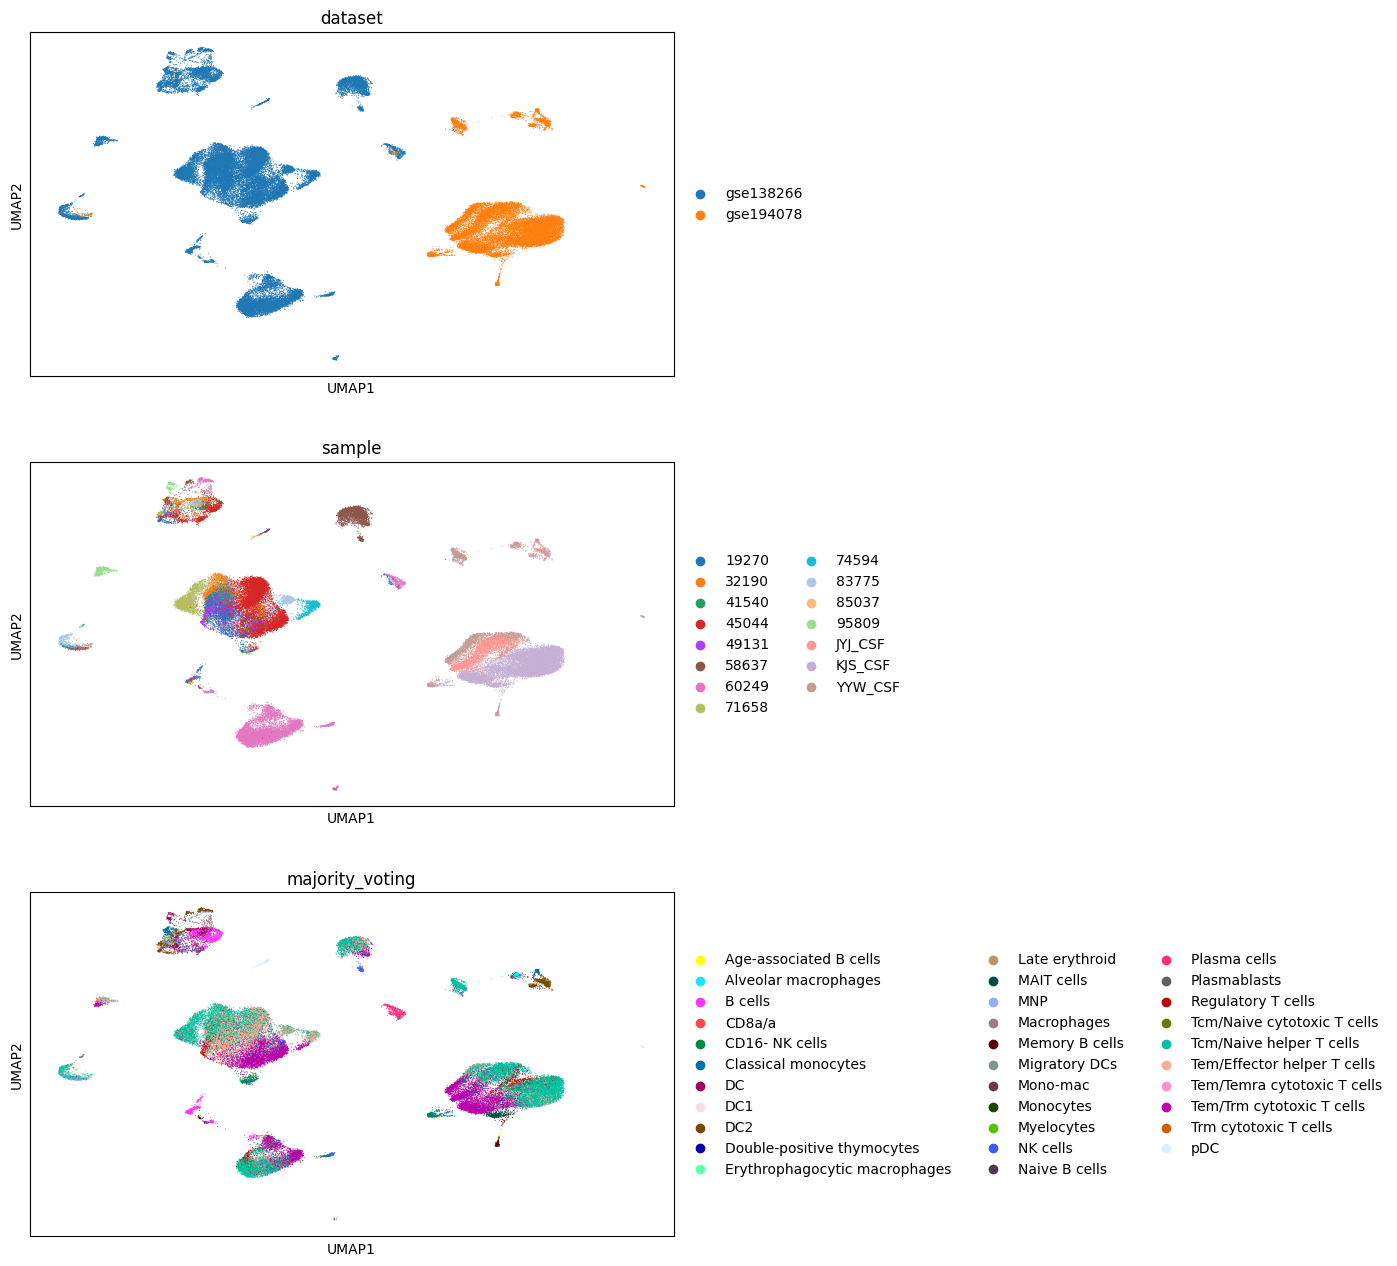

In [40]:
sc.pl.umap(
    concat_anndata,
    color=["dataset", "sample", "majority_voting"],
    # Setting a smaller point size to get prevent overlap
    size=2,
    wspace=0.4,
    ncols=1
)

In [41]:
concat_anndata.obs['majority_voting'].value_counts()

majority_voting
Tcm/Naive helper T cells         19910
Tem/Trm cytotoxic T cells        11561
Tem/Effector helper T cells      10058
B cells                           1468
Regulatory T cells                1434
DC2                               1354
DC                                1102
CD16- NK cells                     676
NK cells                           554
MAIT cells                         536
Alveolar macrophages               394
Plasma cells                       392
MNP                                376
pDC                                374
Classical monocytes                366
Mono-mac                           296
Macrophages                        294
Memory B cells                     212
Tcm/Naive cytotoxic T cells        139
CD8a/a                             125
DC1                                 97
Myelocytes                          86
Trm cytotoxic T cells               77
Tem/Temra cytotoxic T cells         69
Erythrophagocytic macrophages       63
Naive B c

In [42]:
# Define the mapping from specific to generalized cell types
cell_type_mapping = {
    # CD4 T cells (Helper, Regulatory)
    'Tcm/Naive helper T cells': 'CD4 T',
    'Tem/Effector helper T cells': 'CD4 T',
    'Regulatory T cells': 'CD4 T',

    # CD8 T cells (Cytotoxic, Memory)
    'Tem/Trm cytotoxic T cells': 'CD8 T',
    'Tcm/Naive cytotoxic T cells': 'CD8 T',
    'Trm cytotoxic T cells': 'CD8 T',
    'Tem/Temra cytotoxic T cells': 'CD8 T',
    'CD8a/a': 'CD8 T', # Often associated with CD8 lineage

    # B lineage cells (including Plasma cells as requested)
    'B cells': 'B & Plasma Cells',
    'Memory B cells': 'B & Plasma Cells',
    'Naive B cells': 'B & Plasma Cells',
    'Age-associated B cells': 'B & Plasma Cells',
    'Plasma cells': 'B & Plasma Cells',
    'Plasmablasts': 'B & Plasma Cells',

    # NK cells
    'CD16- NK cells': 'NK cells',
    'NK cells': 'NK cells',

    # Monocytes
    'Classical monocytes': 'Monocytes',
    'Monocytes': 'Monocytes',

    # Macrophages
    'Alveolar macrophages': 'Macrophages',
    'Macrophages': 'Macrophages',
    'Erythrophagocytic macrophages': 'Macrophages',

    # Dendritic Cells (Grouping conventional and plasmacytoid for simplicity, could be separated)
    'DC2': 'Dendritic Cells',
    'DC': 'Dendritic Cells',
    'DC1': 'Dendritic Cells',
    'pDC': 'Dendritic Cells', # Plasmacytoid DCs
    'Migratory DCs': 'Dendritic Cells',

    # Ambiguous/Mixed Myeloid (Monocyte/Macrophage lineage)
    'MNP': 'Monocyte/Macrophage', # Mononuclear Phagocyte
    'Mono-mac': 'Monocyte/Macrophage',

    # Other T cells / Immature T
    'MAIT cells': 'Other T cells',
    'Double-positive thymocytes': 'Immature T cells',

    # Myeloid Progenitors
    'Myelocytes': 'Myeloid Progenitors',

    # Erythroid Lineage
    'Late erythroid': 'Erythroid cells',
}

# Example usage with your function (assuming concat_anndata exists)
# adata_generalized = generalize_cell_types(concat_anndata, mapping=cell_type_mapping)

# If you want to modify the function to accept the mapping directly:
import pandas as pd # Make sure pandas is imported if not already

def generalize_cell_types(adata, obs_column='majority_voting',
                           mapping=None, new_column_name='generalized_celltype'):
    """
    Generalizes cell type labels in an AnnData object's .obs column based on a provided mapping.

    Args:
        adata: AnnData object containing cell type annotations in .obs.
        obs_column: Name of the .obs column containing cell type labels (default: 'majority_voting').
        mapping: A dictionary specifying how to map original cell type labels to generalized labels.
                 If None, uses a default mapping (updated to be empty or raise error, as a default is less useful without context).
        new_column_name: Name of the new column to create in adata.obs (default: 'generalized_celltype').


    Returns:
        AnnData: The modified AnnData object.
    """

    if mapping is None:
        # Option 1: Raise an error if no mapping is provided
        raise ValueError("A mapping dictionary must be provided.")
        # Option 2: Use an empty mapping (less useful)
        # mapping = {}
        # Option 3: Keep the original default (less relevant now)
        # mapping = { ... default mapping ... }


    # Ensure the obs_column exists
    if obs_column not in adata.obs.columns:
        raise ValueError(f"Column '{obs_column}' not found in adata.obs")

    # Map the values, keep original if not in mapping
    adata.obs[new_column_name] = adata.obs[obs_column].map(mapping).fillna(adata.obs[obs_column])

    # Convert to categorical for efficiency if desired
    adata.obs[new_column_name] = pd.Categorical(adata.obs[new_column_name])

    print(f"Value counts for new column '{new_column_name}':")
    print(adata.obs[new_column_name].value_counts())
    return adata

# --- How to use it ---
# 1. Define your AnnData object (e.g., concat_anndata)
# 2. Define the mapping dictionary (cell_type_mapping from above)
# 3. Call the function:
# concat_anndata = generalize_cell_types(
#     concat_anndata,
#     obs_column='majority_voting', # Or your specific column name
#     mapping=cell_type_mapping,
#     new_column_name='broad_cell_type' # Choose your desired output column name
# )

concat_anndata = generalize_cell_types(concat_anndata, obs_column='majority_voting', mapping=cell_type_mapping, new_column_name='generalized_celltype')


Value counts for new column 'generalized_celltype':
generalized_celltype
CD4 T                  31402
CD8 T                  11971
Dendritic Cells         2935
B & Plasma Cells        2203
NK cells                1230
Macrophages              751
Monocyte/Macrophage      672
Other T cells            536
Monocytes                424
Myeloid Progenitors       86
Erythroid cells           41
Immature T cells          11
Name: count, dtype: int64


In [43]:
print(concat_anndata)

AnnData object with n_obs × n_vars = 52262 × 17820
    obs: 'condition', 'sample', 'tissue', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'predicted_labels', 'over_clustering', 'majority_voting', 'dataset', 'generalized_celltype'
    var: 'mt'
    uns: 'dataset_colors', 'sample_colors', 'majority_voting_colors', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'


### INTEGRAZIONE EFFETTIVA (SCGEN)

In [44]:
import scgen
import scanpy as sc
scgen.SCGEN.setup_anndata(concat_anndata, batch_key="sample", labels_key="generalized_celltype")

In [45]:
concat_anndata.obs_names_make_unique()
print(concat_anndata)

AnnData object with n_obs × n_vars = 52262 × 17820
    obs: 'condition', 'sample', 'tissue', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'predicted_labels', 'over_clustering', 'majority_voting', 'dataset', 'generalized_celltype', '_scvi_batch', '_scvi_labels'
    var: 'mt'
    uns: 'dataset_colors', 'sample_colors', 'majority_voting_colors', 'pca', 'neighbors', 'umap', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'


In [46]:
model = scgen.SCGEN(concat_anndata)
#model.save("dataset/models/Integrazione_ben_fatta", overwrite=True)

In [47]:
model.train(
    max_epochs=100,
    batch_size=64,
    early_stopping=True,
    early_stopping_patience=25
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 25 records. Best score: 2078.470. Signaling Trainer to stop.


In [48]:
corrected_adata = model.batch_removal()
corrected_adata

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:617: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:617: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:617: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The r

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


AnnData object with n_obs × n_vars = 52262 × 17820
    obs: 'condition', 'sample', 'tissue', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'predicted_labels', 'over_clustering', 'majority_voting', 'dataset', 'generalized_celltype', '_scvi_batch', '_scvi_labels', 'concat_batch'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'latent', 'corrected_latent'

In [49]:
corrected_adata.write("CSF INTEGRATO BATCH 64 KEY SAMPLE.h5ad", compression="gzip")

In [50]:
print("Running PCA...")
sc.pp.pca(
    corrected_adata,
    n_comps=50,  # Or another value based on the dataset's complexity.
    svd_solver="auto",  # Let Scanpy choose the best solver.
    random_state=0,  # For reproducibility.  Remove if not needed.
    zero_center=True,  # Center data before PCA.  Generally a good idea.
)

print("Finding neighbors...")
rsc.pp.neighbors(
    corrected_adata,
    n_neighbors=60,  # Adjust based on dataset size; higher for larger datasets.
    n_pcs=None,  # Use all computed PCs; reduce if memory is an issue.
    use_rep="X_pca",  # Specify PCA result as the basis for neighbor search.
    random_state=0,  # For reproducibility.  Remove if not needed.
)

print("Running UMAP on GPU")
rsc.tl.umap(
    corrected_adata,
    #min_dist=0.2,  # Adjust for clumpiness of the embedding.
    #spread=1.5,  # Adjust the balance between local and global structure.
    random_state=0,  # For reproducibility.  Remove if not needed.
    # use_gpu=True, #Enable it in your scanpy setting
)

Running PCA...
Finding neighbors...
Running UMAP on GPU


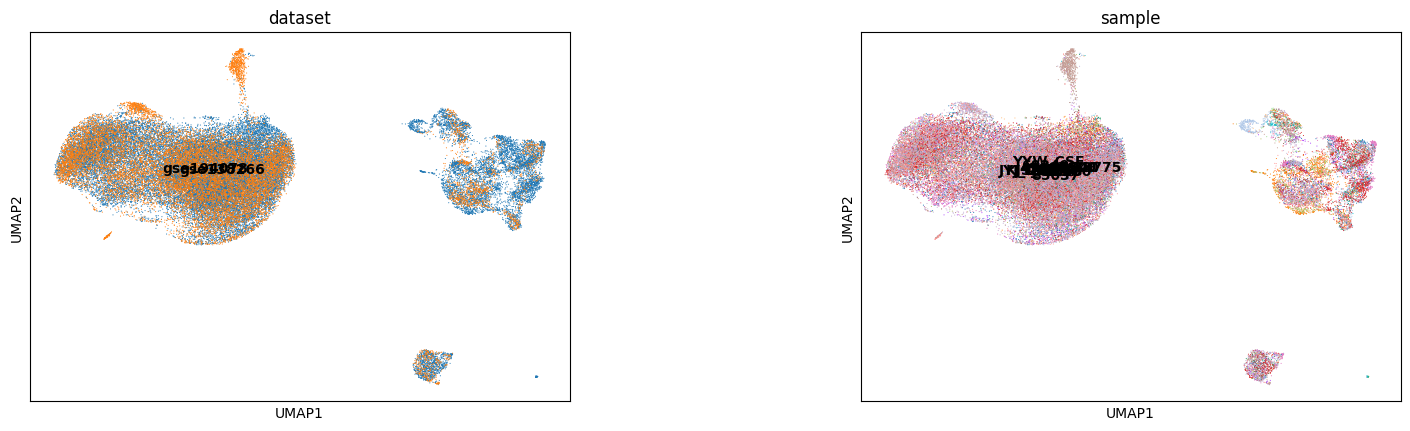

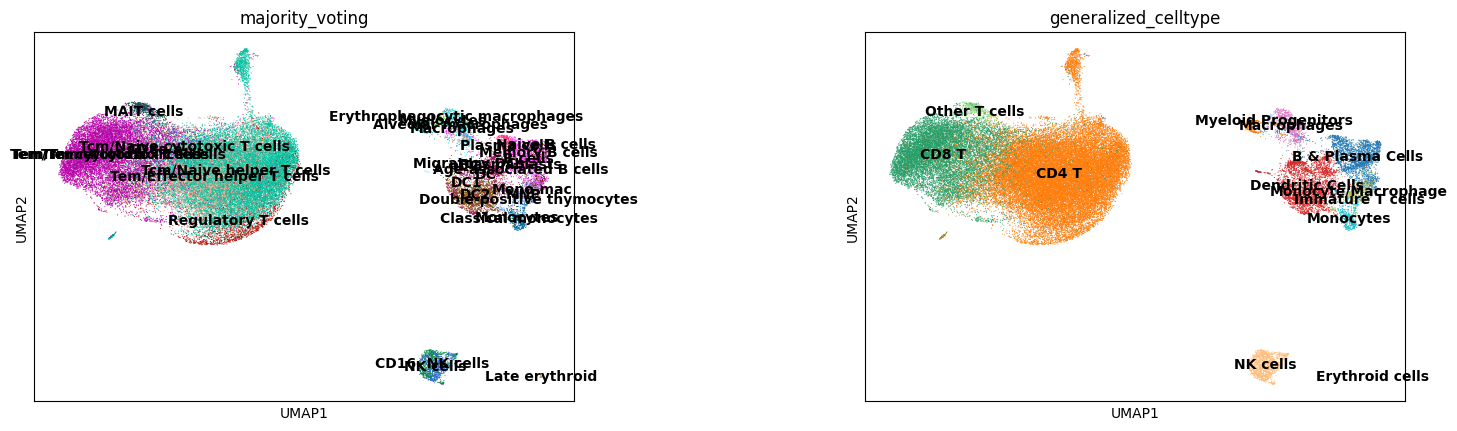

In [51]:
sc.pl.umap(corrected_adata, color=["dataset","sample"], wspace=0.4, legend_loc="on data", ncols=2)
sc.pl.umap(corrected_adata, color=["majority_voting","generalized_celltype"], wspace=0.4, legend_loc="on data", ncols=2)

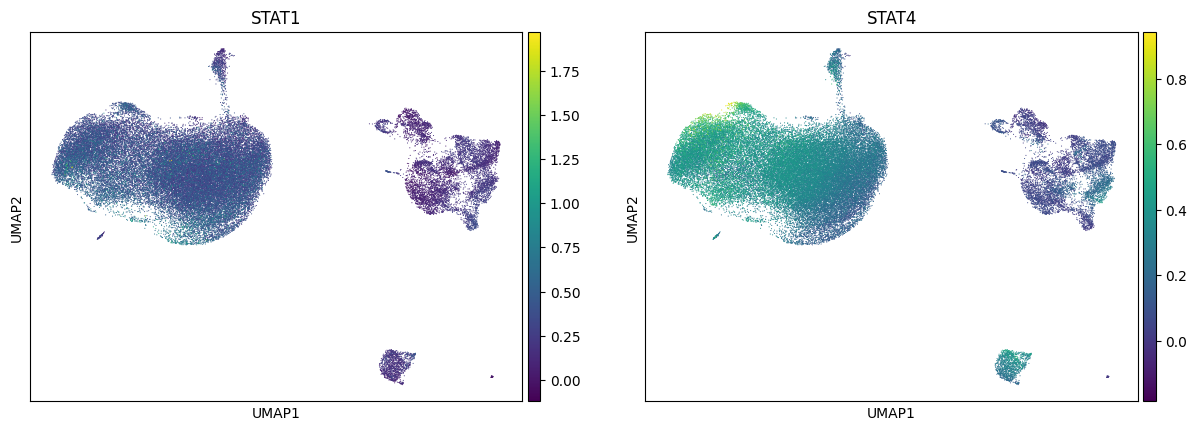

In [52]:
sc.pl.umap(corrected_adata, color=["STAT1","STAT4"], ncols=2)

In [21]:
import pandas as pd
markers = pd.read_csv('../MarcatoriTh1Th17TReg.csv')
markers = markers.drop_duplicates(subset=['genesymbol', 'cell_type']) # Ensure 'source' and 'target' cols exist
print(markers)

   genesymbol  cell_type
0         CD4  CD4+ Th17
1       IL17A  CD4+ Th17
2        RORC  CD4+ Th17
3        CSF2  CD4+ Th17
4       STAT3  CD4+ Th17
5        CCR6  CD4+ Th17
6        RORA  CD4+ Th17
7        BATF  CD4+ Th17
8       IL23R  CD4+ Th17
9        IRF4  CD4+ Th17
10        CD4   CD4+ Th1
11       IFNG   CD4+ Th1
12      CXCR3   CD4+ Th1
13      TBX21   CD4+ Th1
14      STAT1   CD4+ Th1
15        CD4  CD4+ TReg
16      FOXP3  CD4+ TReg
17       CD25  CD4+ TReg
18      IL2RA  CD4+ TReg
19       IL7R  CD4+ TReg
20       IL10  CD4+ TReg
21      CTLA4  CD4+ TReg
22      CD274  CD4+ TReg
23       CCR1   CD4+ Th1
24       CCR4  CD4+ Th17
25       CCR5   CD4+ Th1
27        CD3  CD4+ Th17
28        CD3   CD4+ Th1
29     IFNGR1   CD4+ Th1
30      IFNGR   CD4+ Th1
31    IL12RB2   CD4+ Th1
32     IL18R1   CD4+ Th1
33      IL1R1  CD4+ Th17
34      IL21R  CD4+ Th17
36       IL6R  CD4+ Th17
37      STAT4   CD4+ Th1
38       TBET   CD4+ Th1
39     TGFBR2  CD4+ Th17


In [58]:
corrected_adata.write("csf_int.h5ad", compression="gzip")

In [3]:
corrected_adata = sc.read_h5ad("csf_int.h5ad")

In [55]:
corrected_adata.obs["majority_voting"].value_counts()

majority_voting
Tcm/Naive helper T cells         19910
Tem/Trm cytotoxic T cells        11561
Tem/Effector helper T cells      10058
B cells                           1468
Regulatory T cells                1434
DC2                               1354
DC                                1102
CD16- NK cells                     676
NK cells                           554
MAIT cells                         536
Alveolar macrophages               394
Plasma cells                       392
MNP                                376
pDC                                374
Classical monocytes                366
Mono-mac                           296
Macrophages                        294
Memory B cells                     212
Tcm/Naive cytotoxic T cells        139
CD8a/a                             125
DC1                                 97
Myelocytes                          86
Trm cytotoxic T cells               77
Tem/Temra cytotoxic T cells         69
Erythrophagocytic macrophages       63
Naive B c

In [61]:
import anndata as ad
import pandas as pd
from typing import Optional, List, Union, Sequence # For type hinting

def extract_cell_types( # Renamed function slightly for clarity
    adata: ad.AnnData,
    annotation_column: str,
    target_cell_types: Union[str, Sequence[str]] # Accept single string or list/tuple/etc.
) -> Optional[ad.AnnData]:
    """
    Extracts a subset of an AnnData object based on one or more cell type labels.

    Args:
        adata: The input AnnData object.
        annotation_column: The name of the column in adata.obs containing
                           cell type annotations (e.g., 'majority_voting').
        target_cell_types: A specific cell type label (string) or a list/tuple
                           of cell type labels to extract.

    Returns:
        A new AnnData object containing only the cells matching any of the
        target_cell_types. Returns None if no matching cells are found.

    Raises:
        KeyError: If the specified annotation_column does not exist in adata.obs.
        TypeError: If adata is not an AnnData object or other inputs have
                   incorrect types.
    """
    # --- Input Validation ---
    if not isinstance(adata, ad.AnnData):
        raise TypeError("Input 'adata' must be an AnnData object.")
    if not isinstance(annotation_column, str):
        raise TypeError("Input 'annotation_column' must be a string.")

    # Ensure target_cell_types is a list, even if a single string was passed
    if isinstance(target_cell_types, str):
        targets = [target_cell_types]
    elif isinstance(target_cell_types, Sequence) and not isinstance(target_cell_types, str):
        # Check if all elements in the sequence are strings
        if not all(isinstance(item, str) for item in target_cell_types):
             raise TypeError("If 'target_cell_types' is a sequence, all its elements must be strings.")
        targets = list(target_cell_types) # Convert to list for consistency
    else:
        raise TypeError("Input 'target_cell_types' must be a string or a sequence (list, tuple) of strings.")

    if not targets:
        print("Warning: Empty list provided for 'target_cell_types'. Returning None.")
        return None

    if annotation_column not in adata.obs.columns:
        raise KeyError(
            f"Annotation column '{annotation_column}' not found in adata.obs. "
            f"Available columns are: {list(adata.obs.columns)}"
        )

    print(f"Attempting to extract cells matching {targets} using column '{annotation_column}'...")
    print(f"Original AnnData shape: {adata.shape}")

    # --- Create Mask and Subset ---
    # Use .isin() to check if the cell type is in the target list
    cell_mask = adata.obs[annotation_column].isin(targets)

    # Count how many cells match
    num_matches = cell_mask.sum()

    if num_matches > 0:
        print(f"Found {num_matches} matching cells. Creating subset...")
        # Subset the AnnData object using the boolean mask
        # Use .copy() to create a new object, not just a view
        adata_subset = adata[cell_mask, :].copy()
        print(f"Successfully created subset with shape: {adata_subset.shape}")
        return adata_subset
    else:
        print(
            f"Warning: No cells found matching any of {targets} in "
            f"column '{annotation_column}'. Returning None."
        )
        return None



In [68]:
# Make sure the function definition for extract_cell_types is executed first!

# Now call the correct function:
b_cell_subset = extract_cell_types( # Use the function that accepts lists
    adata=corrected_adata,
    annotation_column="majority_voting",
    target_cell_types=['B cells', 'Memory B cells', 'Age-associated B cells'] # Pass the list here
)
b_cell_subset.write("../dataset/matrici_addestramento/bcells_csf.h5ad", compression='gzip')

Attempting to extract cells matching ['B cells', 'Memory B cells', 'Age-associated B cells'] using column 'majority_voting'...
Original AnnData shape: (52262, 17820)
Found 1706 matching cells. Creating subset...
Successfully created subset with shape: (1706, 17820)


In [99]:
# Now call the correct function:
b_cell_subset = extract_cell_types( # Use the function that accepts lists
    adata=corrected_adata,
    annotation_column="generalized_celltype",
    target_cell_types=["B & Plasma Cells"] # Pass the list here
)

b_cell_subset = remove_clusters(
    b_cell_subset,
    "majority_voting",
    "Naive B cells"
)
b_cell_subset.write("../dataset/matrici_addestramento/bcells_csf.h5ad", compression='gzip')

Attempting to extract cells matching ['B & Plasma Cells'] using column 'generalized_celltype'...
Original AnnData shape: (52262, 17820)
Found 2203 matching cells. Creating subset...
Successfully created subset with shape: (2203, 17820)
Original number of cells: 2203
Attempting to remove clusters: ['Naive B cells'] from column 'majority_voting'
Removed 60 cells belonging to clusters: ['Naive B cells'].
New number of cells: 2143

Remaining clusters in 'majority_voting':
majority_voting
B cells                   1468
Plasma cells               392
Memory B cells             212
Plasmablasts                45
Age-associated B cells      26
Name: count, dtype: int64


In [69]:
# Make sure the function definition for extract_cell_types is executed first!

# Now call the correct function:
treg_subset = extract_cell_types( # Use the function that accepts lists
    adata=corrected_adata,
    annotation_column="majority_voting",
    target_cell_types=['Regulatory T cells'] # Pass the list here
)
treg_subset.write("../dataset/matrici_addestramento/treg_csf.h5ad", compression='gzip')

Attempting to extract cells matching ['Regulatory T cells'] using column 'majority_voting'...
Original AnnData shape: (52262, 17820)
Found 1434 matching cells. Creating subset...
Successfully created subset with shape: (1434, 17820)


In [71]:
print(b_cell_subset.obs["condition"].value_counts())
print(treg_subset.obs["condition"].value_counts())


condition
CTRL    988
MS      718
Name: count, dtype: int64
condition
MS      1320
CTRL     114
Name: count, dtype: int64


#### Identificazione del gruppo di CD4+

Tcm/Naive helper T cells, Tem/Effector helper T cells.

Dobbiamo eliminare le Naive.

In [72]:
CD4 = extract_cell_types(adata=corrected_adata, 
                         annotation_column='majority_voting', 
                         target_cell_types=["Tcm/Naive helper T cells","Tem/Effector helper T cells"])

Attempting to extract cells matching ['Tcm/Naive helper T cells', 'Tem/Effector helper T cells'] using column 'majority_voting'...
Original AnnData shape: (52262, 17820)
Found 29968 matching cells. Creating subset...
Successfully created subset with shape: (29968, 17820)


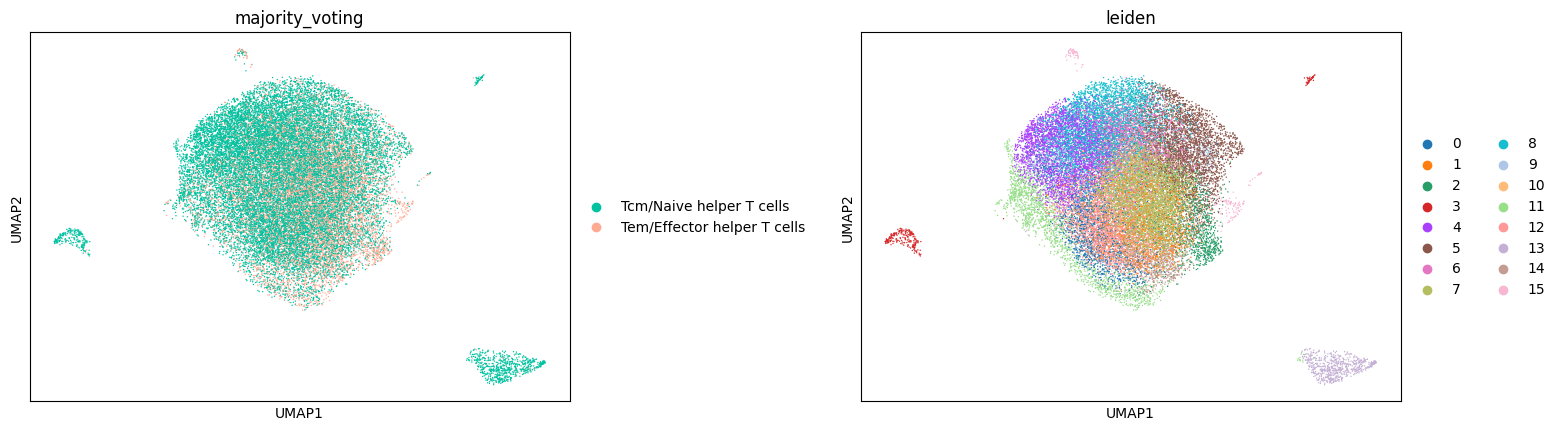

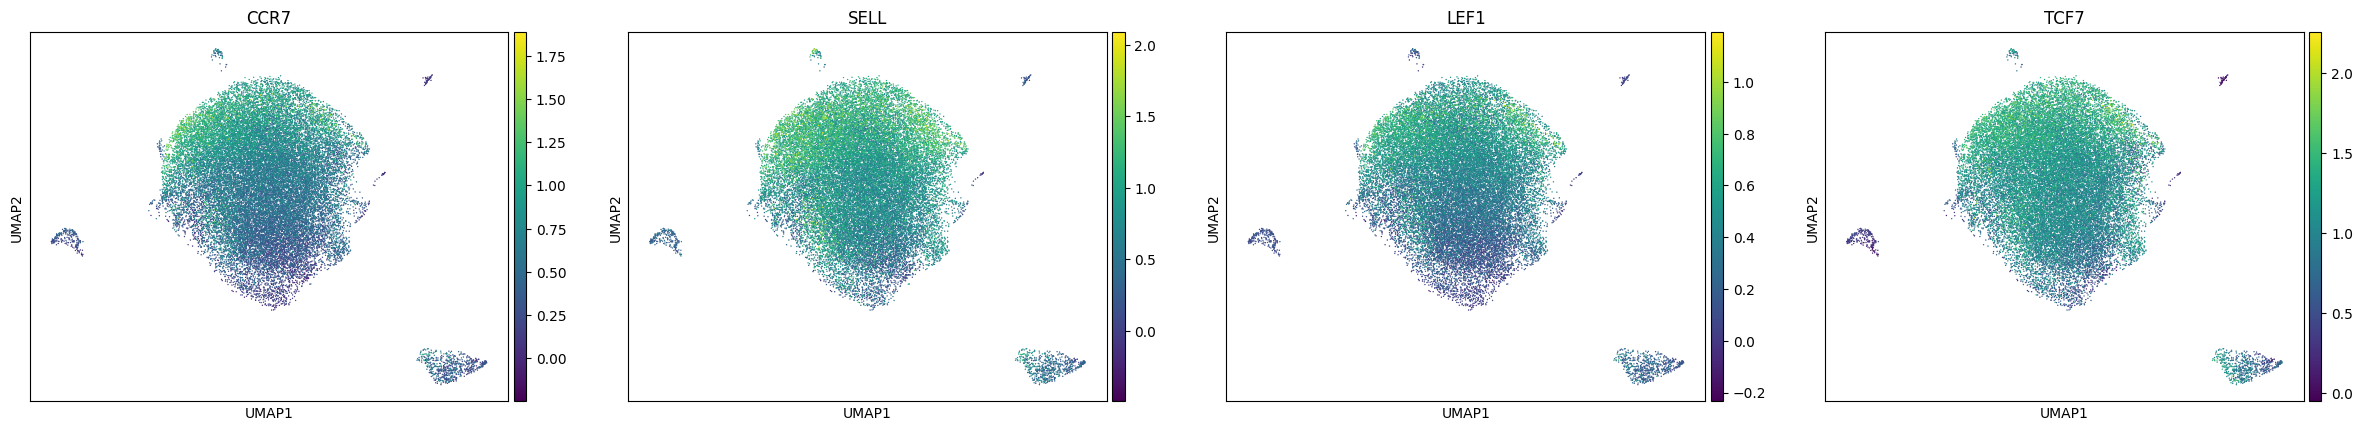

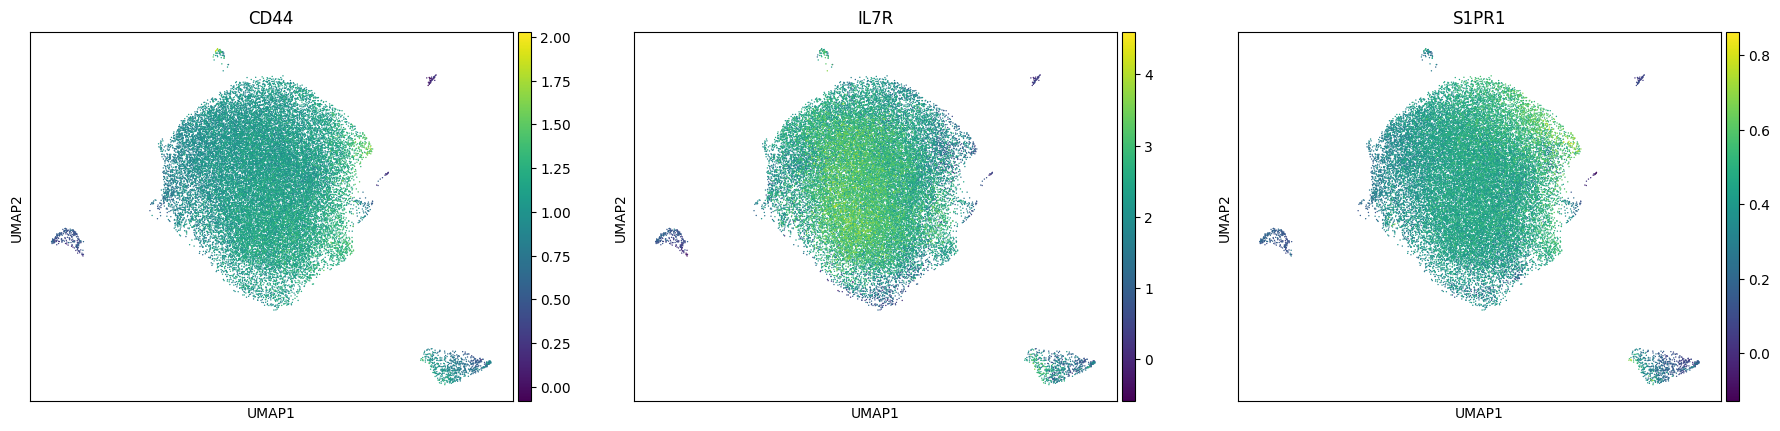

In [85]:
rsc.pp.neighbors(CD4)
rsc.tl.umap(CD4, random_state=0)
rsc.tl.leiden(CD4, resolution=1.2)
sc.pl.umap(CD4, color=["majority_voting", "leiden"], wspace=0.4)
sc.pl.umap(CD4,color = ['CCR7', 'SELL', 'LEF1', 'TCF7']) #naive
sc.pl.umap(CD4, color=['CD44', 'IL7R', 'S1PR1'] ) # memory marker

In [86]:
def remove_clusters(
    adata: sc.AnnData,
    cluster_column: str,
    clusters_to_remove: Union[str, List[str]],
    verbose: bool = True,
) -> Optional[sc.AnnData]:
    """
    Removes specified clusters from an AnnData object.

    Args:
        adata: The AnnData object to filter.
        cluster_column: The name of the column in adata.obs containing
                        cluster labels (e.g., 'leiden', 'louvain').
        clusters_to_remove: A single cluster ID (string) or a list of
                            cluster IDs (strings) to remove.
        verbose: If True, print information about the filtering process.

    Returns:
        A new AnnData object with the specified clusters removed, or None
        if the cluster column doesn't exist. Returns the original adata
        if no valid clusters to remove are found.
    """
    # --- Input Validation ---
    if not isinstance(adata, sc.AnnData):
        print("Error: Input 'adata' must be an AnnData object.")
        return None

    if cluster_column not in adata.obs.columns:
        print(
            f"Error: Cluster column '{cluster_column}' not found in adata.obs."
        )
        return None

    # Ensure clusters_to_remove is a list
    if isinstance(clusters_to_remove, str):
        clusters_to_remove = [clusters_to_remove]
    elif not isinstance(clusters_to_remove, list):
        print(
            "Error: 'clusters_to_remove' must be a string or a list of strings."
        )
        return None

    # Check if cluster IDs are strings (common for Leiden/Louvain)
    if not all(isinstance(c, str) for c in clusters_to_remove):
         print("Warning: Cluster IDs are typically strings. Ensure they match the data type in adata.obs.")

    # --- Filtering Logic ---
    original_n_obs = adata.n_obs
    if verbose:
        print(f"Original number of cells: {original_n_obs}")
        print(f"Attempting to remove clusters: {clusters_to_remove} from column '{cluster_column}'")

    # Check which of the requested clusters actually exist in the data
    valid_clusters_to_remove = [
        c for c in clusters_to_remove
        if c in adata.obs[cluster_column].astype(str).unique() # Cast to string for comparison
    ]

    if not valid_clusters_to_remove:
        if verbose:
            print(f"Warning: None of the specified clusters {clusters_to_remove} found in '{cluster_column}'. Returning original AnnData object.")
        return adata # Or return adata.copy() if you always want a copy

    # Create the boolean mask for cells to KEEP
    # Use .astype(str) to handle potential categorical types correctly
    mask_keep = ~adata.obs[cluster_column].astype(str).isin(valid_clusters_to_remove)

    # Filter the AnnData object and create a copy
    adata_filtered = adata[mask_keep, :].copy()

    # --- Output ---
    if verbose:
        n_removed = original_n_obs - adata_filtered.n_obs
        print(f"Removed {n_removed} cells belonging to clusters: {valid_clusters_to_remove}.")
        print(f"New number of cells: {adata_filtered.n_obs}")
        if cluster_column in adata_filtered.obs.columns:
             print(f"\nRemaining clusters in '{cluster_column}':")
             print(adata_filtered.obs[cluster_column].value_counts())


    return adata_filtered

In [87]:
CD4T_no_naive = remove_clusters(CD4, "leiden", clusters_to_remove=["8"])

Original number of cells: 29968
Attempting to remove clusters: ['8'] from column 'leiden'
Removed 4284 cells belonging to clusters: ['8'].
New number of cells: 25684

Remaining clusters in 'leiden':
leiden
7     4671
4     3607
5     3280
12    3003
6     2019
11    1783
0     1662
1     1639
2     1059
14     904
13     657
9      528
10     422
3      265
15     185
Name: count, dtype: int64


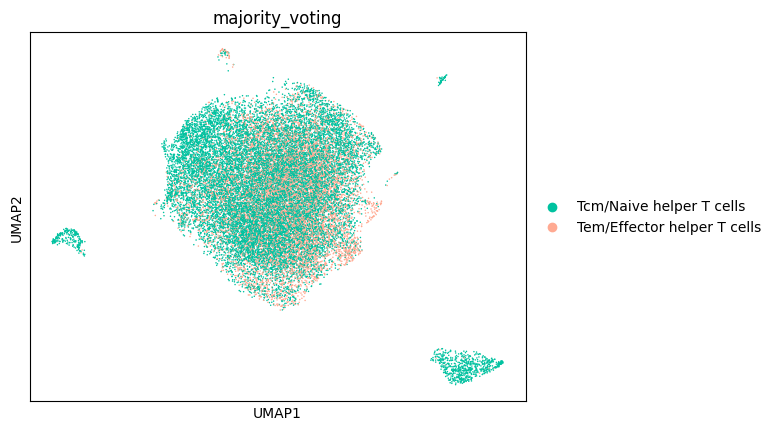

In [89]:
sc.pl.umap(CD4T_no_naive, color="majority_voting")

In [91]:
CD4T_no_naive.obs["condition"].value_counts()

condition
MS      17852
CTRL     7832
Name: count, dtype: int64

In [92]:
CD4T_no_naive.write("../dataset/matrici_addestramento/CD4TNONAIVE_csf.h5ad", compression="gzip")

['CD4 T', 'Myeloid Progenitors', 'Dendritic Cells', 'CD8 T', 'Monocytes', 'B & Plasma Cells', 'Macrophages', 'Monocyte/Macrophage', 'NK cells', 'Erythroid cells', 'Other T cells', 'Immature T cells']
